# Figure 5: Integrating GWAS summary statistic data with scRNA data

In [1]:
import pandas as pd
import scanpy as sc
from anndata import AnnData
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sc.set_figure_params(dpi_save = 300, frameon = False)

FIGSIZE = (10,8)
rcParams["figure.figsize"] = FIGSIZE

In [4]:
import os
os.chdir('/g/data/ei56/pa3687/projects/bal-manuscript-2025-revisions/')

In [5]:
data = sc.read_h5ad('data/BAL_FINAL.h5ad')

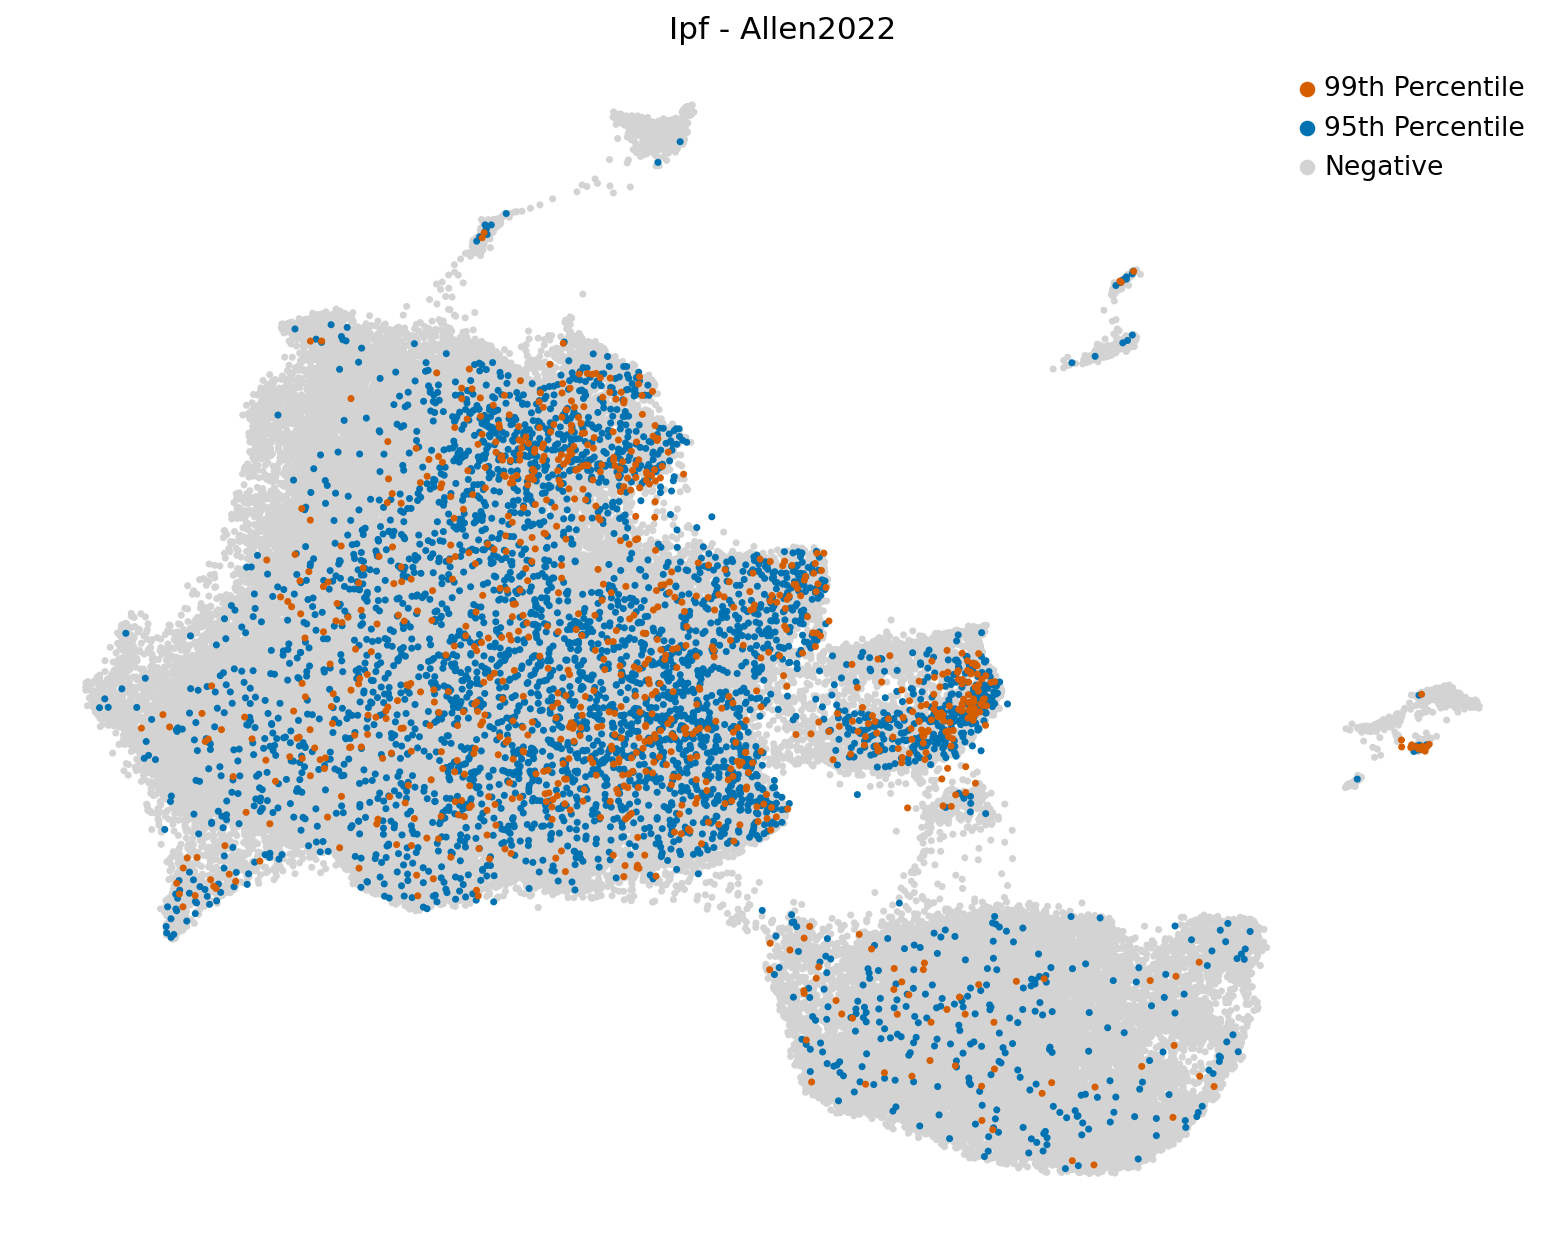

In [7]:
trait = 'ipf_allen2022'

dict_score = {
    trait: pd.read_csv(f"data/scdrs/{trait}.full_score.gz", sep="\t", index_col=0)
}

# Append "norm_score" from ipf_allen2022 to adata
data.obs[trait] = data.obs.index.map(dict_score[trait]["norm_score"])

# Create a new column for positive/negative cells based on the threshold
threshold_95 = data.obs[trait].quantile(0.95)
threshold_99 = data.obs[trait].quantile(0.99)
data.obs[f'{trait}_binary'] = data.obs[trait].apply(
    lambda x: 'Top1' if x > threshold_99 else ('Top5' if x > threshold_95 else 'Negative')
)

# Define the color palette for positive and negative cells
palette = {'Top1': '#d55e00', 'Top5': '#0072b2', 'Negative': 'lightgray'}

# Sort the data so that Top1 points are plotted on top, then Top5, then Negative
data_sorted = data[data.obs[f'{trait}_binary'] == 'Negative'].concatenate(
    data[data.obs[f'{trait}_binary'] == 'Top5']
).concatenate(
    data[data.obs[f'{trait}_binary'] == 'Top1']
)

# Plot the UMAP with the binary classification
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(data_sorted, color=f'{trait}_binary', palette=palette, save=False, 
           frameon=False, size=40, title=f'{trait.replace("_", " - ").title()}',
           ax=ax, show=False)

handles, labels = ax.get_legend_handles_labels()

label_mapping = {
    'Top1': '99th Percentile',
    'Top5': '95th Percentile', 
    'Negative': 'Negative'
}

# Update labels and reorder
new_handles = []
new_labels = []
for desired_label in ['Top1', 'Top5', 'Negative']:
    if desired_label in labels:
        idx = labels.index(desired_label)
        new_handles.append(handles[idx])
        new_labels.append(label_mapping[desired_label])

ax.legend(new_handles, new_labels, loc='best', fontsize=12, frameon=False)

plt.tight_layout()
plt.show()

## Subset to MLMs

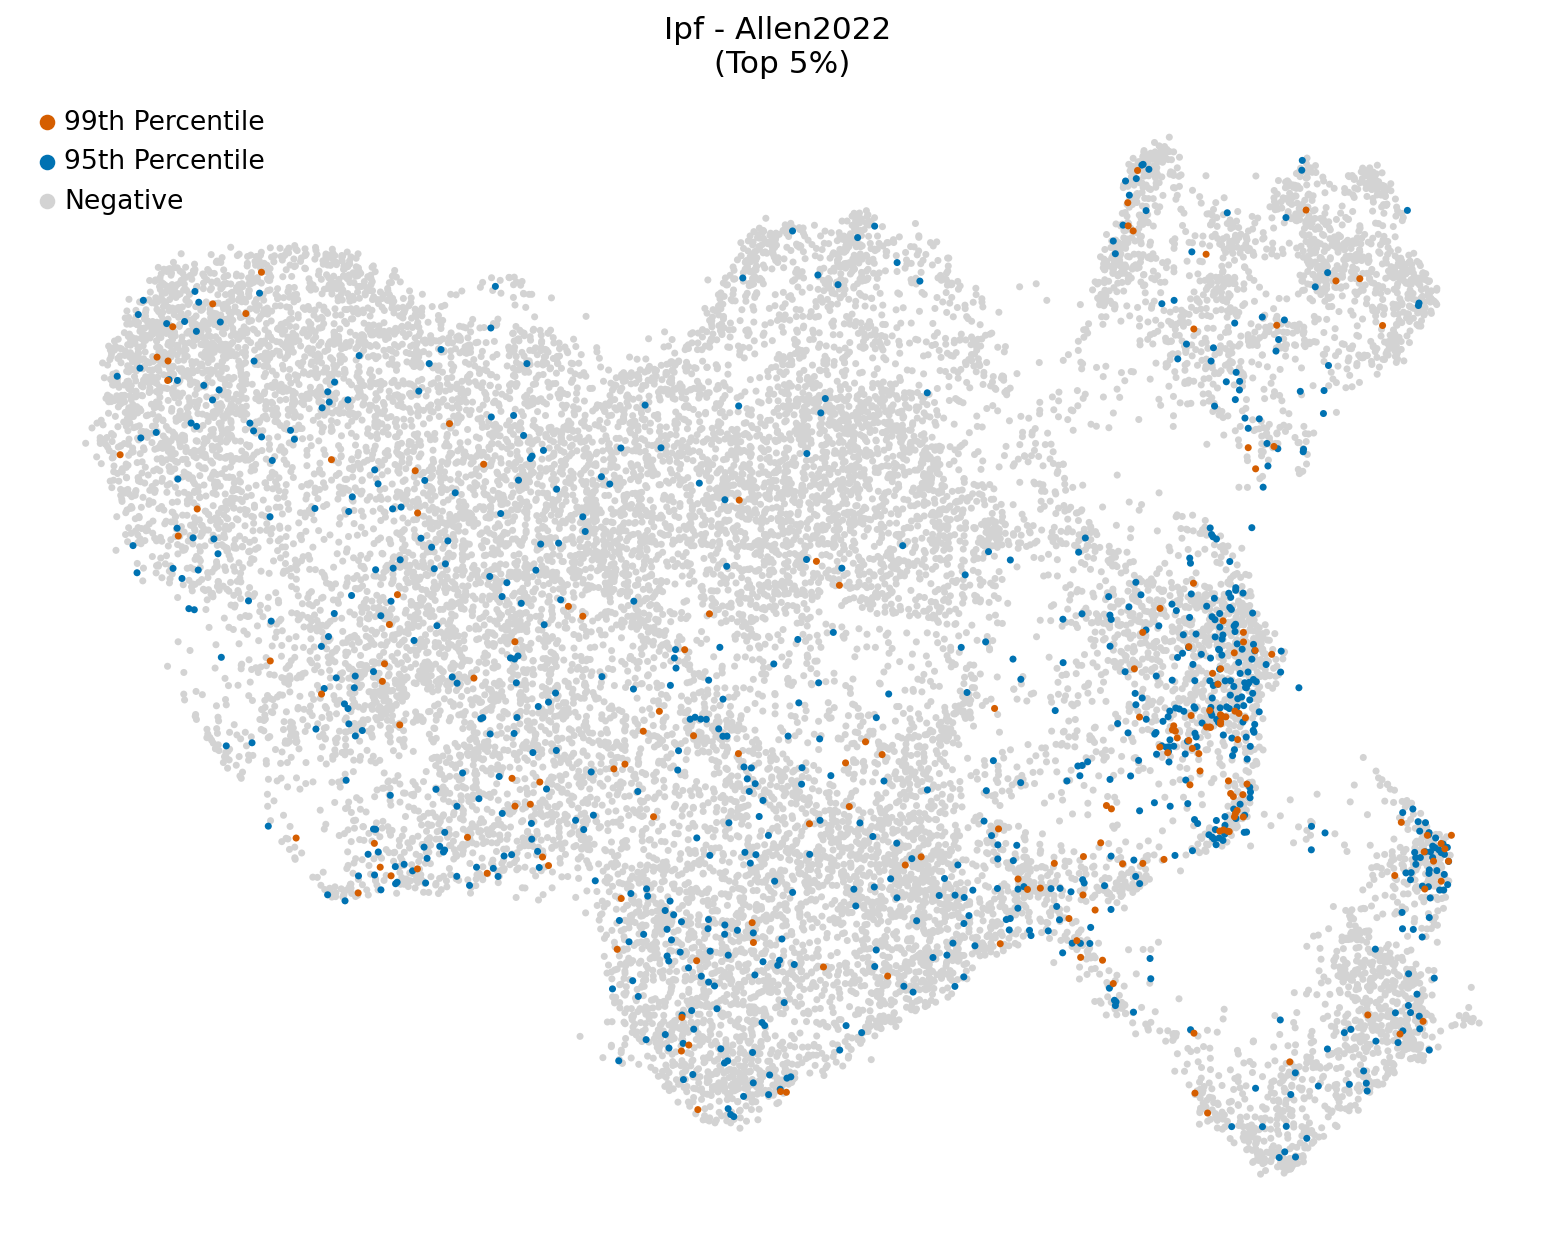

In [10]:
celltypes = ['Alveolar macrophage', 'Monocyte-like macrophage', 'Proliferating alveolar macrophage', 'Interstitial-like macrophage']
data = data[data.obs['Cell_Subtype'].isin(celltypes)]

# Initialize the subtype column - convert to string first to avoid categorical issues
data.obs['myeloid_subtype'] = data.obs['Cell_Sub_subtype'].astype(str)

# Assign Cell_Sub_subtype based on mdm_clusters values
mapping = {
    'MLM0': 'MLM_0',
    'MLM1': 'MLM_1',
    'IL1Bhi MLM': 'IL1B+ Macrophage',
    'CXCL10hi MLM': 'CXCL10+ Macrophage',
    'CCL2hi MLM': 'CCL2+ Macrophage',
    'SPP1hi MLM': 'SPP1+ Macrophage'
}

# Apply the mapping only where keys exist, keep original values otherwise
data.obs['myeloid_subtype'] = data.obs['myeloid_subtype'].apply(
    lambda x: mapping.get(x, x)
)

# Subset data to include only those listed in the map function
valid_subtypes = ['MLM_0', 'MLM_1', 'IL1B+ Macrophage', 'CXCL10+ Macrophage', 'CCL2+ Macrophage', 'SPP1+ Macrophage']
data = data[data.obs['myeloid_subtype'].isin(valid_subtypes)]

# Define custom colors for specific myeloid_subtype to match trajectory
custom_colors = {
    'MLM_0': '#a6cee4',
    'MLM_1': '#2178b3',
    'IL1B+ Macrophage': '#b2df8a',
    'CXCL10+ Macrophage': '#32a02d',
    'CCL2+ Macrophage': '#fb9b99',
    'SPP1+ Macrophage': '#0ea8e8'
}

# Remove NaN values and convert to category
data = data[data.obs['myeloid_subtype'].notna()]
data.obs['myeloid_subtype'] = data.obs['myeloid_subtype'].astype('category')

# Import the MLM UMAP Embeddings
mlm_umap = pd.read_csv('data/mlm_umap_embeddings.csv', index_col=0)
aligned_umap = mlm_umap.reindex(data.obs.index)
data.obsm['X_umap'] = aligned_umap[['umap_1', 'umap_2']].values

# Top 5% for the selected trait
threshold_95 = data.obs[trait].quantile(0.95)
threshold_99 = data.obs[trait].quantile(0.99)
data.obs[f'{trait}_binary'] = data.obs[trait].apply(
    lambda x: 'Top1' if x > threshold_99 else ('Top5' if x > threshold_95 else 'Negative')
)

# Sort the data so that Positive points are plotted on top
palette = {'Top1': '#d55e00', 'Top5': '#0072b2', 'Negative': 'lightgray'}

# Sort the data so that Top1 points are plotted on top, then Top5, then Negative
data_sorted = data[data.obs[f'{trait}_binary'] == 'Negative'].concatenate(
    data[data.obs[f'{trait}_binary'] == 'Top5']
).concatenate(
    data[data.obs[f'{trait}_binary'] == 'Top1']
)

# Plot the UMAP with the binary classification
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(data_sorted, color=f'{trait}_binary', palette=palette, save=False, 
           frameon=False, size=40, title=f'{trait.replace("_", " - ").title()} \n(Top 5%)',
           ax=ax, show=False)

# Modify the legend
handles, labels = ax.get_legend_handles_labels()

# Create mapping for labels
label_mapping = {
    'Top1': '99th Percentile',
    'Top5': '95th Percentile', 
    'Negative': 'Negative'
}

# Update labels and reorder
new_handles = []
new_labels = []
for desired_label in ['Top1', 'Top5', 'Negative']:
    if desired_label in labels:
        idx = labels.index(desired_label)
        new_handles.append(handles[idx])
        new_labels.append(label_mapping[desired_label])

ax.legend(new_handles, new_labels, loc='best', fontsize=12, frameon=False)

plt.tight_layout()
plt.show()